This notebook models classifiers to detect if a given county is a close result in the 2016 election (labeled "swing") or not (labeled "safe"). Interpretable models will be used to investigate which features indicate a battleground county. Models prioritize sensitivity (higher true positive rate) with recall score.

# Imports

In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## sklearn

In [334]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# pca
from sklearn import decomposition
# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## other

In [3]:
# upsampling with SMOTE
from imblearn import over_sampling
from imblearn.pipeline import Pipeline as imbPipeline

## Plot Settings

In [4]:
# format style
plt.style.use('fivethirtyeight')
# lineweight
plt.rc('lines', linewidth=3)
# figure size
plt.rc('figure', figsize=(12, 7))
# title fontsize
plt.rc('axes', titlesize=22) 
# axes label fontsize
plt.rc('axes', labelsize=18)
# axes values fontsize
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
# legend fontsize
plt.rc('legend', fontsize=16)

# Custom Functions

## Space Log
Return range of numbers between two values in a log scale

In [5]:
def space_log(start, stop, number):
    return(np.exp(np.linspace(np.log(start), np.log(stop), number)))

# Data

In [6]:
df = pd.read_pickle('data/dataframe.pkl')
df.head()

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate,close_elect
0,55504.0,1.7,20800.0,37.8,39721.0,54487.0,3.9,13.5,87.6,24.6,93.371913,0.762305,0.025512,0
1,212628.0,16.7,75149.0,42.3,41286.0,56460.0,4.0,11.7,90.0,29.5,133.746808,0.810999,0.040973,0
2,25270.0,-8.0,9122.0,38.7,31788.0,32884.0,5.9,29.9,73.8,12.9,28.557545,0.491888,0.045390,0
3,22668.0,-1.1,7048.0,40.2,29264.0,43079.0,4.4,20.1,80.7,12.0,36.409779,0.766278,0.022146,0
4,58013.0,1.2,20619.0,40.8,31470.0,47213.0,4.0,14.1,80.0,13.0,89.973324,0.949322,0.086808,0


## NaN values

In [7]:
# drop rows with nans
df = df.dropna()

## EDA

In [8]:
# sns.pairplot(df);

In [9]:
# inspect mean values of features for not-close vs close outcomes
df.groupby('close_elect').mean()

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate
close_elect,,,,,,,,,,,,,
0,97754.622861,0.673854,35383.793292,41.180151,40647.942847,49173.193018,4.611328,15.914203,85.657392,20.269884,251.164202,0.838362,0.088684
1,213686.159236,2.568153,77334.891720,38.888535,42207.388535,53773.019108,4.530573,15.549045,88.495541,27.620382,317.779807,0.760183,0.095176


In [10]:
close = (df['close_elect'] == 1).sum()
not_close = (df['close_elect'] == 0).sum()

In [11]:
# baseline, null model accuracy - guess '0' every time
(df['close_elect'] == 0).sum() / len(df)

0.9490094186424164

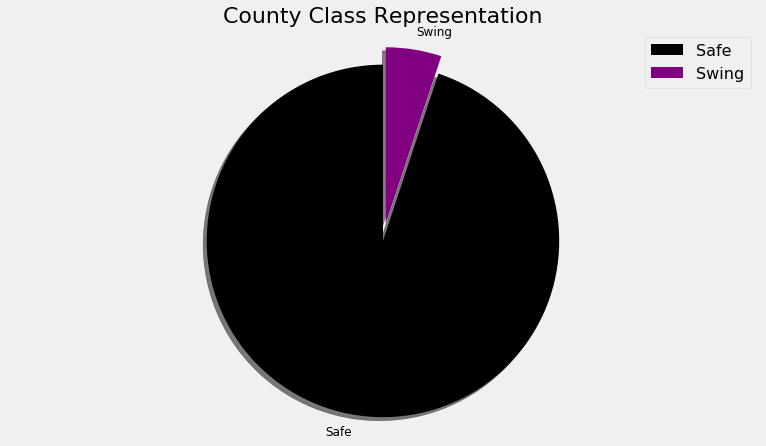

In [12]:
# plot pie chart

sizes = [not_close, close]
explode = (0, 0.1)
colors = ['black', 'purple']

fig, ax = plt.subplots()
ax.pie(sizes, labels=['Safe', 'Swing'], explode=explode, colors=colors,
        shadow=True, startangle=90)
ax.axis('equal') # circle shape
ax.set_title('County Class Representation')
ax.legend();

**Notes**
- Data is extremely unbalanced  
- "Safe" counties are much more prevalent in data (about 95% of observations)
- A model could attain 95% accuracy by always predicting "safe" counties!

# Pre-processing

In [13]:
# initialize feature dataframe and observed outcome
X = df.iloc[:, 0:13]
y = df.iloc[:, 13]

## Train/test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Scaling

In [15]:
# scale data to have mean = 0 and variance = 1
scaler = preprocessing.StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

## Principle Component Analysis (PCA)
Reduce dimensionality of data to 2-D so that grouping trends can potentially be visualized

In [16]:
# decomposition to 2-D
pca = decomposition.PCA(n_components=2)
pca_features = pca.fit_transform(X_train_scl)

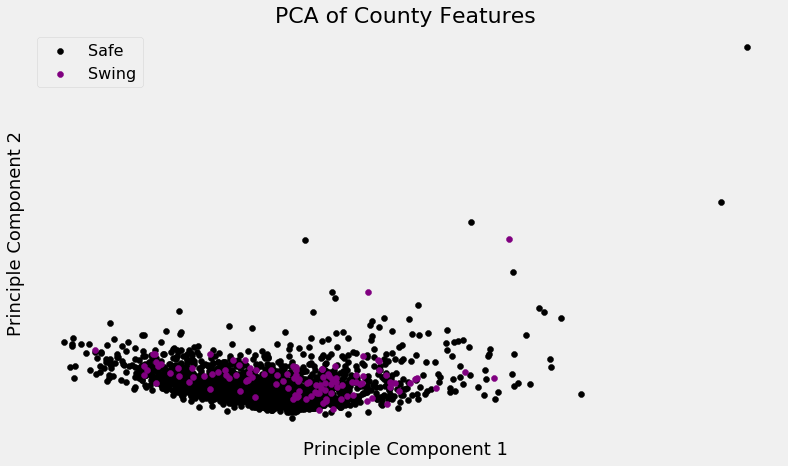

In [17]:
# plot components
class_labels = ['Safe', 'Swing']
colors = ['black', 'purple']

plt.figure()
for i, label in enumerate(class_labels):
    plt.scatter(pca_features[y_train == i, 0], pca_features[y_train == i, 1],
                label=label, c=colors[i])
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('PCA of County Features')
plt.xticks([]) # component valuables not interpretable
plt.yticks([]) # component valuables not interpretable
plt.legend();

**Notes**  
Swing counties seem to have a grouping trend but are not separated from safe counties

# Logistic Regression Modeling

## Initial Model

In [18]:
# model pipeline includes scaling
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression())
])

In [19]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [20]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       729
          1       0.00      0.00      0.00        41

avg / total       0.90      0.95      0.92       770



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
metrics.confusion_matrix(y_test, log_pred)

array([[729,   0],
       [ 41,   0]])

**Notes**
- model does not accurately predict any swing counties  
    - this is a result of the severe imbalance of classes in the dataset
- recall is to be prioritized
    - this will help the model capture more swing counties (label 1)
    - may result in more false positives and reduced overall accuracy

## Tuning with GridSearch
Tune model hyperparameter for optimal model performance

In [22]:
# try range of values for C and penalty hyperparameters
hyperparams = {'model__penalty':['l1', 'l2'], 'model__C': space_log(0.001, 100, 15)}

In [23]:
# tune model pipeline for recall
log_tune = GridSearchCV(log_pipe, hyperparams, cv=10, scoring='recall')

In [24]:
log_tune.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__penalty': ['l1', 'l2'], 'model__C': array([1.00000e-03, 2.27585e-03, 5.17947e-03, 1.17877e-02, 2.68270e-02,
       6.10540e-02, 1.38950e-01, 3.16228e-01, 7.19686e-01, 1.63789e+00,
       3.72759e+00, 8.48343e+00, 1.93070e+01, 4.39397e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [25]:
# assign best hyperparameter values from tuning
best_penalty = log_tune.best_params_['model__penalty']
best_C = log_tune.best_params_['model__C']

In [26]:
# model pipeline with optimal hyperparameters
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(penalty=best_penalty, C=best_C))
])

In [27]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [28]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       729
          1       0.00      0.00      0.00        41

avg / total       0.90      0.95      0.92       770



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
metrics.confusion_matrix(y_test, log_pred)

array([[729,   0],
       [ 41,   0]])

**Notes**  
Tuning did not increase recall for swing counties

## Balanced Weights
Modifies "weights" of classes in algorithm's cost function to place greater importance on minority class  
Balanced weights are inversly proportional to the frequency of class observations

In [30]:
# model pipeline with class weights set to balanced
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced'))
])

In [31]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [32]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.98      0.77      0.86       729
          1       0.15      0.71      0.24        41

avg / total       0.93      0.77      0.83       770



In [33]:
metrics.confusion_matrix(y_test, log_pred)

array([[562, 167],
       [ 12,  29]])

**Notes**  
This greatly increased recall for label 1 classification  
Try tuning this model

In [34]:
hyperparams = {'model__penalty':['l1', 'l2'], 'model__C': space_log(0.001, 100, 15)}
log_tune = GridSearchCV(log_pipe, hyperparams, cv=10, scoring='recall')
log_tune.fit(X_train, y_train)
best_penalty_bal = log_tune.best_params_['model__penalty']
best_C_bal = log_tune.best_params_['model__C']

In [35]:
# update hyperparameters in pipeline
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(penalty=best_penalty_bal, C=best_C_bal, class_weight='balanced'))
])

In [36]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [37]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.98      0.71      0.82       729
          1       0.13      0.78      0.22        41

avg / total       0.94      0.71      0.79       770



In [38]:
metrics.confusion_matrix(y_test, log_pred)

array([[516, 213],
       [  9,  32]])

**Notes**  
Model performance increased with tuning

## Synthetic Minority Over-sampling Technique (SMOTE)
Oversampling method that generates synthetic samples of the minority class

In [39]:
# model pipeline with SMOTE applied
log_pipe = imbPipeline([
    ('oversample', over_sampling.SMOTE(random_state=0)),
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression())    
])

In [40]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [41]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.97      0.78      0.86       729
          1       0.13      0.59      0.21        41

avg / total       0.93      0.76      0.83       770



In [42]:
metrics.confusion_matrix(y_test, log_pred)

array([[565, 164],
       [ 17,  24]])

**Notes**  
This greatly increased recall for label 1 classification compared with initial model  
Try tuning this model

In [43]:
hyperparams = {'model__penalty':['l1', 'l2'], 'model__C': space_log(0.001, 100, 15)}
log_tune = GridSearchCV(log_pipe, hyperparams, cv=10, scoring='recall')
log_tune.fit(X_train, y_train)
best_penalty_smt = log_tune.best_params_['model__penalty']
best_C_smt = log_tune.best_params_['model__C']

In [44]:
# update hyperparameters in pipeline
log_pipe = imbPipeline([
    ('oversample', over_sampling.SMOTE(random_state=0)),
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(penalty=best_penalty_smt, C=best_C_smt))    
])

In [45]:
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)

In [46]:
print(metrics.classification_report(y_test, log_pred))

             precision    recall  f1-score   support

          0       0.97      0.77      0.86       729
          1       0.13      0.63      0.22        41

avg / total       0.93      0.76      0.82       770



In [47]:
metrics.confusion_matrix(y_test, log_pred)

array([[559, 170],
       [ 15,  26]])

**Notes**  
Model performance increased with tuning

## Final Model
Tuned model with balanced weights

In [275]:
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(penalty=best_penalty_bal, C=best_C_bal, class_weight='balanced'))
])

In [276]:
log_pipe.fit(X_train, y_train)
log_predict = log_pipe.predict(X_test)

### Evaluation

In [277]:
print(metrics.classification_report(y_test, log_predict))

             precision    recall  f1-score   support

          0       0.98      0.71      0.82       729
          1       0.13      0.78      0.22        41

avg / total       0.94      0.71      0.79       770



In [278]:
metrics.confusion_matrix(y_test, log_predict)

array([[516, 213],
       [  9,  32]])

In [52]:
# probabilities of swing county for each observation
log_predict_proba = log_pipe.predict_proba(X_test)[:, 1]

#### Receiver Operating Characteristic (ROC)

In [53]:
# create ROC curve data
# returns false positive rate, true positive rate for range of thresholds
log_fpr, log_tpr, log_thresh = roc_curve(y_test, log_predict_proba)

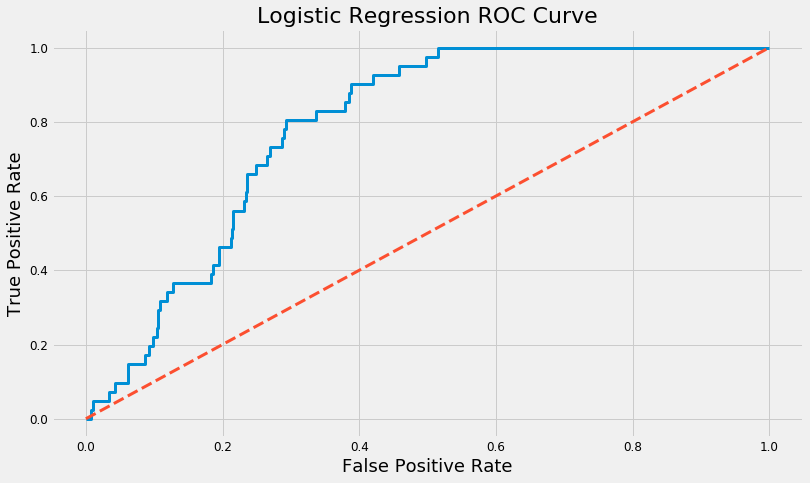

In [54]:
plt.plot(log_fpr, log_tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve');

#### Area Under the Curve (AUC) Score

In [55]:
roc_auc_score(y_test, log_predict_proba)

0.7865100873230955

**Notes**  
Model performance appears to be pretty good based on the AUC. However, this is due to the high class imbalance in the dataset. This is not the best evaluation metric for this analysis.

#### Precision-Recall

In [56]:
# create precision recall curve data
# returns precision, recall for range of thresholds
log_pre, log_rec, log_thresh = precision_recall_curve(y_test, log_predict_proba)

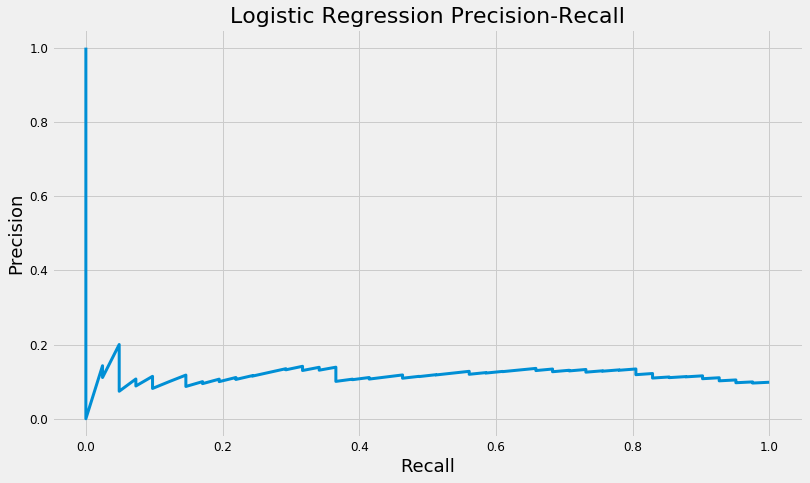

In [57]:
plt.plot(log_rec, log_pre)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression Precision-Recall');

#### Area Under the Curve (AUC) Score

In [58]:
auc(log_rec, log_pre)

0.11590327717655888

**Notes**  
The precision-recall curve gives a better representation of model performance.

# Random Forest Modeling

## Initial Model

In [59]:
rf = RandomForestClassifier(random_state=0) # note scaling not required

In [60]:
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [61]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       729
          1       0.00      0.00      0.00        41

avg / total       0.90      0.95      0.92       770



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [62]:
metrics.confusion_matrix(y_test, rf_pred)

array([[729,   0],
       [ 41,   0]])

**Notes**
- model does not accurately predict many swing counties  
    - this is a result of the severe imbalance of classes in the dataset
- recall is to be prioritized
    - this will help the model capture more swing counties (label 1)
    - may result in more false positives and reduced overall accuracy

## Tuning with RandomizedSearch
Tune model hyperparameter for optimal model performance

In [63]:
# try range of values for hyperparameters

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features to consider at every split
max_features = np.arange(1, X.shape[1]+1)
# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]

In [64]:
hyperparams = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [65]:
# tune model pipeline for recall
rf_tune = RandomizedSearchCV(RandomForestClassifier(random_state=0), hyperparams, 
                           scoring='recall', cv=5, random_state=0)

In [66]:
rf_tune.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring='recall', verbose=0

In [67]:
rf_pred = rf_tune.predict(X_test)

In [68]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97       729
          1       0.00      0.00      0.00        41

avg / total       0.90      0.93      0.91       770



In [69]:
metrics.confusion_matrix(y_test, rf_pred)

array([[719,  10],
       [ 41,   0]])

In [70]:
# assign best hyperparameter values from tuning
best_n_estimators = rf_tune.best_params_['n_estimators']
best_max_features = rf_tune.best_params_['max_features']
best_max_depth = rf_tune.best_params_['max_depth']
best_min_samples_split = rf_tune.best_params_['min_samples_split']
best_min_samples_leaf = rf_tune.best_params_['min_samples_leaf']
best_bootstrap = rf_tune.best_params_['bootstrap']

**Notes**  
Tuning produces no significant improvement in model

## Balanced Weights
Modifies "weights" of classes in algorithm's cost function to place greater importance on minority class  
Balanced weights are inversly proportional to the frequency of class observations

In [71]:
rf = RandomForestClassifier(random_state=0, class_weight='balanced')

In [72]:
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [73]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       729
          1       0.00      0.00      0.00        41

avg / total       0.90      0.95      0.92       770



/home/kevcon/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [74]:
metrics.confusion_matrix(y_test, rf_pred)

array([[729,   0],
       [ 41,   0]])

**Notes**  
Balanced weights shows no improvement

In [75]:
# try range of values for hyperparameters

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features to consider at every split
max_features = np.arange(1, X.shape[1]+1)
# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]

In [76]:
hyperparams = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rf_tune = RandomizedSearchCV(rf, hyperparams, scoring='recall', cv=5, random_state=0)
rf_tune.fit(X_train, y_train)
rf_pred = rf_tune.predict(X_test)

In [77]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       729
          1       0.22      0.20      0.21        41

avg / total       0.92      0.92      0.92       770



In [78]:
metrics.confusion_matrix(y_test, rf_pred)

array([[701,  28],
       [ 33,   8]])

**Notes**  
Model performance increased with tuning

In [80]:
best_n_estimators_bal = rf_tune.best_params_['n_estimators']
best_max_features_bal = rf_tune.best_params_['max_features']
best_max_depth_bal = rf_tune.best_params_['max_depth']
best_min_samples_split_bal = rf_tune.best_params_['min_samples_split']
best_min_samples_leaf_bal = rf_tune.best_params_['min_samples_leaf']
best_bootstrap_bal = rf_tune.best_params_['bootstrap']

## Synthetic Minority Over-sampling Technique (SMOTE)
Oversampling method that generates synthetic samples of the minority class

In [81]:
# model pipeline with SMOTE applied
rf_pipe = imbPipeline([
    ('oversample', over_sampling.SMOTE(random_state=0)),
    ('model', RandomForestClassifier(random_state=0))    
])

In [82]:
rf_pipe.fit(X_train, y_train)
rf_pred = rf_pipe.predict(X_test)

In [83]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

          0       0.96      0.94      0.95       729
          1       0.21      0.29      0.24        41

avg / total       0.92      0.90      0.91       770



In [84]:
metrics.confusion_matrix(y_test, rf_pred)

array([[684,  45],
       [ 29,  12]])

**Notes**  
Some increased recall is observed for label 1 classification compared with initial model  
Try tuning this model

In [85]:
# try range of values for hyperparameters

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features to consider at every split
max_features = np.arange(1, X.shape[1]+1)
# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]

In [86]:
hyperparams = {
    'model__n_estimators': n_estimators,
    'model__max_features': max_features,
    'model__max_depth': max_depth,
    'model__min_samples_split': min_samples_split,
    'model__min_samples_leaf': min_samples_leaf,
    'model__bootstrap': bootstrap
}

rf_tune = RandomizedSearchCV(rf_pipe, hyperparams, scoring='recall', cv=5, random_state=0)
rf_tune.fit(X_train, y_train)
rf_pred = rf_tune.predict(X_test)

In [87]:
print(metrics.classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

          0       0.96      0.91      0.93       729
          1       0.17      0.34      0.23        41

avg / total       0.92      0.88      0.90       770



In [88]:
metrics.confusion_matrix(y_test, rf_pred)

array([[662,  67],
       [ 27,  14]])

In [91]:
best_n_estimators_smt = rf_tune.best_params_['model__n_estimators']
best_max_features_smt = rf_tune.best_params_['model__max_features']
best_max_depth_smt = rf_tune.best_params_['model__max_depth']
best_min_samples_split_smt = rf_tune.best_params_['model__min_samples_split']
best_min_samples_leaf_smt = rf_tune.best_params_['model__min_samples_leaf']
best_bootstrap_smt = rf_tune.best_params_['model__bootstrap']

**Notes**  
Tuning has increased swing recall

## Final Model
Tuned model with SMOTE

In [92]:
rf_pipe = imbPipeline([
    ('oversample', over_sampling.SMOTE(random_state=0)),
    ('model', RandomForestClassifier(random_state=0,
                                     n_estimators=best_n_estimators_smt,
                                     max_features=best_max_features_smt,
                                     max_depth=best_max_depth_smt,
                                     min_samples_split=best_min_samples_split_smt,
                                     min_samples_leaf=best_min_samples_leaf_smt,
                                     bootstrap=best_bootstrap_smt)
    )
])

In [96]:
rf_pipe.fit(X_train, y_train)
rf_predict = rf_pipe.predict(X_test)

### Evaluation

In [97]:
print(metrics.classification_report(y_test, rf_predict))

             precision    recall  f1-score   support

          0       0.96      0.91      0.93       729
          1       0.17      0.34      0.23        41

avg / total       0.92      0.88      0.90       770



In [98]:
metrics.confusion_matrix(y_test, rf_predict)

array([[662,  67],
       [ 27,  14]])

In [99]:
# probabilities of swing county for each observation
rf_predict_proba = rf_pipe.predict_proba(X_test)[:, 1]

#### Receiver Operating Characteristic (ROC)

In [100]:
# create ROC curve data
# returns false positive rate, true positive rate for range of thresholds
rf_fpr, rf_tpr, rf_thresh = roc_curve(y_test, rf_predict_proba)

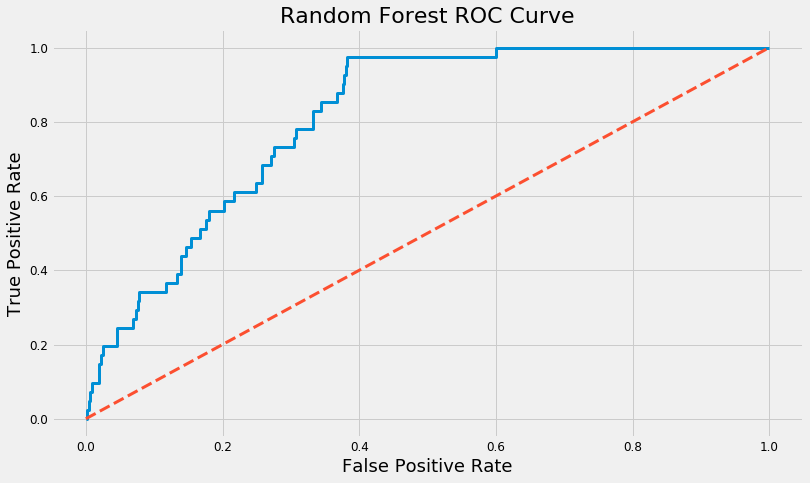

In [101]:
plt.plot(rf_fpr, rf_tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve');

#### Area Under the Curve (AUC) Score

In [102]:
roc_auc_score(y_test, rf_predict_proba)

0.8127070159590485

**Notes**  
Model performance appears to be pretty good based on the AUC. However, this is due to the high class imbalance in the dataset. This is not the best evaluation metric for this analysis.

#### Precision-Recall

In [103]:
# create precision recall curve data
# returns precision, recall for range of thresholds
rf_pre, rf_rec, rf_thresh = precision_recall_curve(y_test, rf_predict_proba)

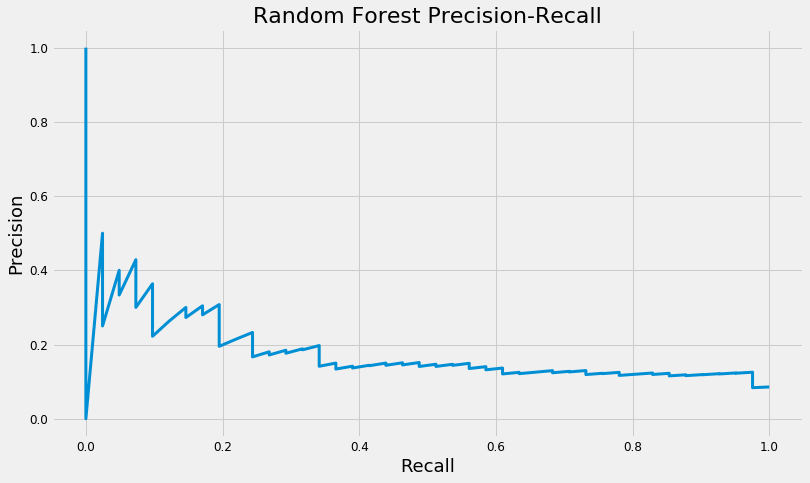

In [104]:
plt.plot(rf_rec, rf_pre)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Precision-Recall');

#### Area Under the Curve (AUC) Score

In [105]:
auc(rf_rec, rf_pre)

0.17166758692210235

**Notes**  
The precision-recall curve gives a better representation of model performance.

# Model Comparison

## Metrics

In [171]:
log_precision, log_recall, log_fscore, log_support = metrics.precision_recall_fscore_support(y_test, log_predict)
rf_precision, rf_recall, rf_fscore, rf_support = metrics.precision_recall_fscore_support(y_test, rf_predict)

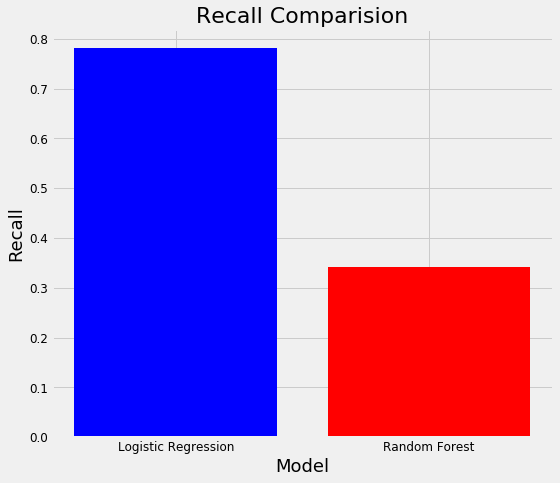

In [176]:
plt.figure(figsize=(8, 7))
plt.bar(range(2), [log_recall[1], rf_recall[1]], color=['b', 'r'])
plt.xticks(range(2), ['Logistic Regression', 'Random Forest'])
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall Comparision');

## ROC

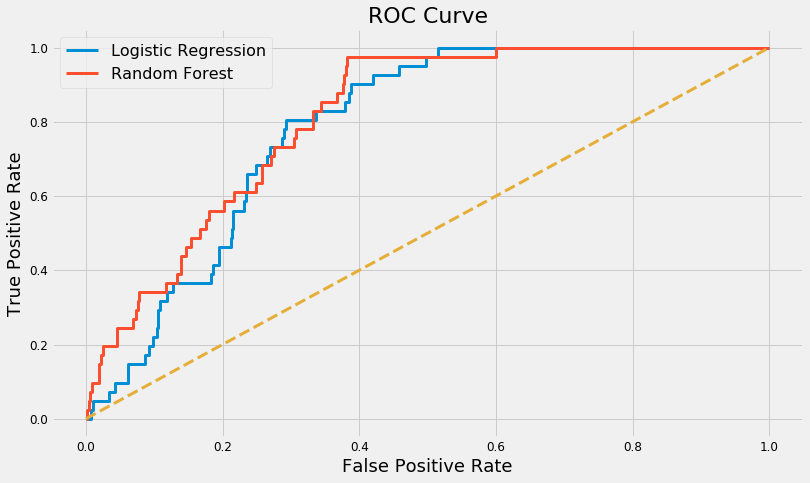

In [123]:
fig, ax = plt.subplots()
ax.plot(log_fpr, log_tpr, label='Logistic Regression')
ax.plot(rf_fpr, rf_tpr, label='Random Forest')
ax.plot([0, 1], [0, 1], linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend();

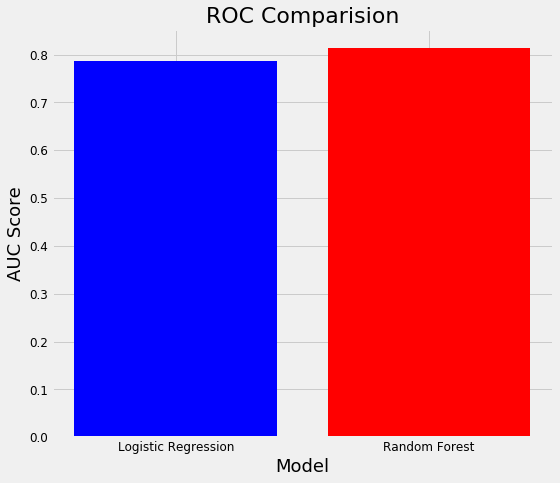

In [144]:
auc_scores = [roc_auc_score(y_test, log_predict_proba), roc_auc_score(y_test, rf_predict_proba)]
plt.figure(figsize=(8, 7))
plt.bar(range(2), auc_scores, color=['b', 'r'])
plt.xticks(range(2), ['Logistic Regression', 'Random Forest'])
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('ROC Comparision');

## Precision-Recall

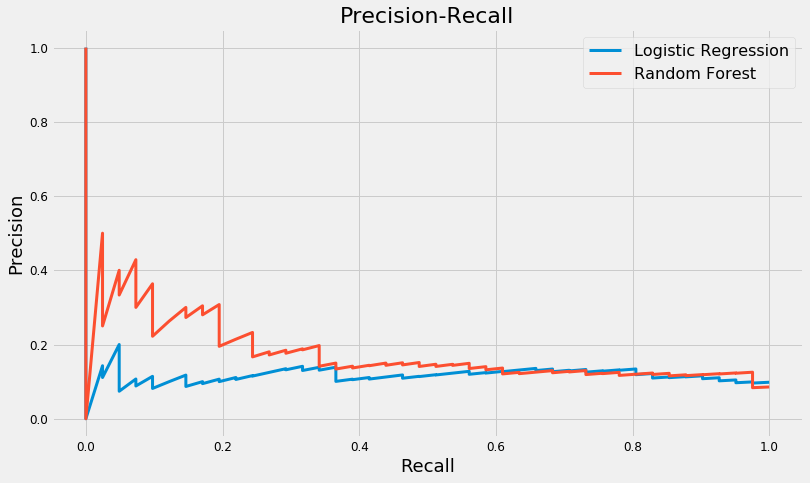

In [109]:
fig, ax = plt.subplots()
ax.plot(log_rec, log_pre, label='Logistic Regression')
ax.plot(rf_rec, rf_pre, label='Random Forest')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall')
ax.legend();

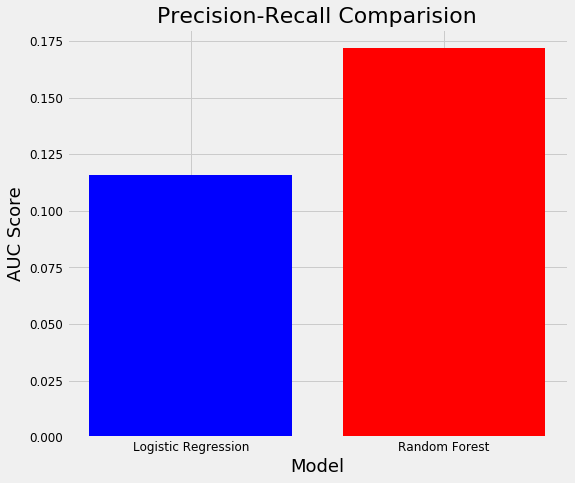

In [143]:
auc_scores = [auc(log_rec, log_pre), auc(rf_rec, rf_pre)]
plt.figure(figsize=(8, 7))
plt.bar(range(2), auc_scores, color=['b', 'r'])
plt.xticks(range(2), ['Logistic Regression', 'Random Forest'])
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('Precision-Recall Comparision');

# Final Analysis
Analysis with Logistic Regression model

## Threshold Modification
Modify decision threshold to capture more of the positive class

In [206]:
# lower probability threshold
threshold = 0.39
log_thresh_predict = log_predict_proba >= threshold

             precision    recall  f1-score   support

          0       1.00      0.46      0.63       729
          1       0.09      1.00      0.17        41

avg / total       0.95      0.49      0.61       770



In [ ]:
print(metrics.classification_report(y_test, log_thresh_predict))

In [207]:
metrics.confusion_matrix(y_test, log_thresh_predict)

array([[337, 392],
       [  0,  41]])

## Logistic Regression Feature Interpretation

In [290]:
log_pipe.named_steps['model'].coef_

array([[ 0.        ,  0.        ,  0.        , -0.00336436, -0.00391475,
         0.        ,  0.        ,  0.        ,  0.        ,  0.67697765,
         0.        , -0.39361472,  0.        ]])

In [291]:
X_train.columns

Index(['population', 'growth', 'households', 'median_age', 'per_cap_income',
       'hh_income', 'unempl_rate', 'poverty_rate', 'hs_rate', 'college_rate',
       'density', 'white_rate', 'hisp_rate'],
      dtype='object')

In [292]:
df_coef = pd.DataFrame(log_pipe.named_steps['model'].coef_, columns=X_train.columns, index=['coefficient']).T
df_coef = df_coef[df_coef['coefficient'] != 0]
df_coef['positive'] = df_coef['coefficient'] > 0
df_coef['coefficient'] = df_coef['coefficient'].apply(abs)
df_coef.sort_values(by='coefficient', ascending=False, inplace=True)
df_coef

,coefficient,positive
college_rate,0.676978,True
white_rate,0.393615,False
per_cap_income,0.003915,False
median_age,0.003364,False


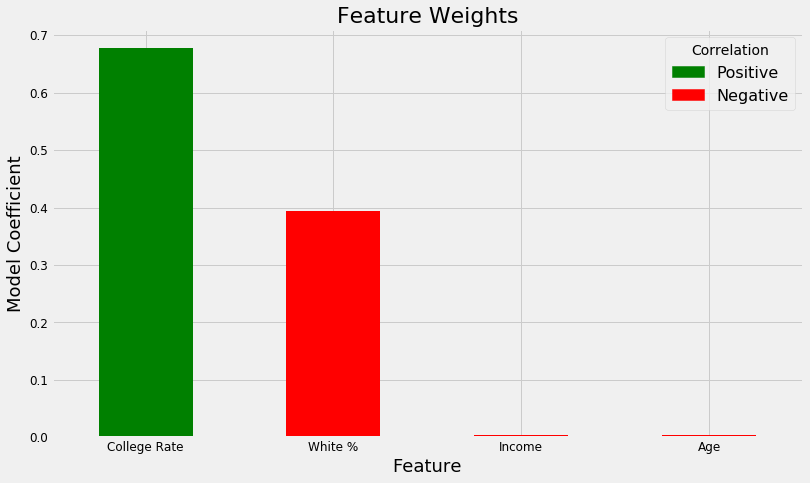

In [310]:
ax = plt.gca()
df_coef['coefficient'].plot(kind='bar', ax=ax, color=df_coef['positive'].map({True: 'g', False: 'r'}))
ax.set_title('Feature Weights')
ax.set_xlabel('Feature')
ax.set_ylabel('Model Coefficient')
ax.set_xticklabels(['College Rate', 'White %', 'Income', 'Age'], rotation=0)

pos_patch = mpatches.Patch(color='green', label='Positive')
neg_patch = mpatches.Patch(color='red', label='Negative')
plt.legend(title='Correlation', handles=[pos_patch, neg_patch]);

## Random Forest Feature Interpretation

In [315]:
rf_pipe.named_steps['model'].feature_importances_

array([0.05869482, 0.04194692, 0.06126835, 0.0330841 , 0.05287077,
       0.04865192, 0.03852907, 0.03859433, 0.0283154 , 0.27953846,
       0.06806361, 0.20280839, 0.04763388])

In [316]:
X_train.columns

Index(['population', 'growth', 'households', 'median_age', 'per_cap_income',
       'hh_income', 'unempl_rate', 'poverty_rate', 'hs_rate', 'college_rate',
       'density', 'white_rate', 'hisp_rate'],
      dtype='object')

In [321]:
df_imp = pd.DataFrame(rf_pipe.named_steps['model'].feature_importances_, 
                      index=X_train.columns, columns=['feat_imp'])
df_imp.sort_values(by='feat_imp', ascending=False, inplace=True)
df_imp

,feat_imp
college_rate,0.279538
white_rate,0.202808
density,0.068064
households,0.061268
population,0.058695
per_cap_income,0.052871
hh_income,0.048652
hisp_rate,0.047634
growth,0.041947
poverty_rate,0.038594


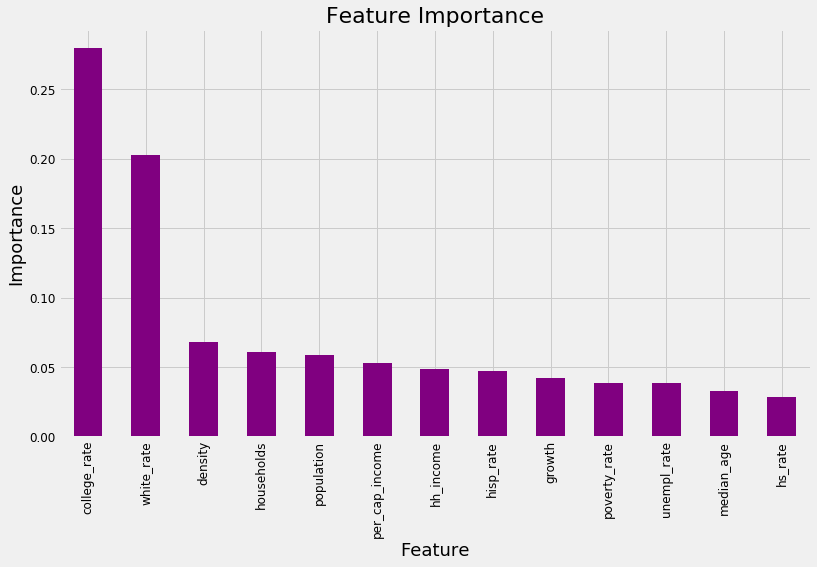

In [347]:
ax = plt.gca()
df_imp['feat_imp'].plot(kind='bar', ax=ax, color='purple')
ax.set_title('Feature Importance')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance');

## Averages of Classes

In [330]:
cls_feat = df.groupby('close_elect').mean().copy()
cls_feat

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate
close_elect,,,,,,,,,,,,,
0,97754.622861,0.673854,35383.793292,41.180151,40647.942847,49173.193018,4.611328,15.914203,85.657392,20.269884,251.164202,0.838362,0.088684
1,213686.159236,2.568153,77334.891720,38.888535,42207.388535,53773.019108,4.530573,15.549045,88.495541,27.620382,317.779807,0.760183,0.095176


In [337]:
cls_feat.sum()

population        311440.782097
growth                 3.242006
households        112718.685012
median_age            80.068686
per_cap_income     82855.331382
hh_income         102946.212127
unempl_rate            9.141901
poverty_rate          31.463247
hs_rate              174.152934
college_rate          47.890266
density              568.944008
white_rate             1.598546
hisp_rate              0.183860
dtype: float64

In [342]:
cls_feat.div(cls_feat.sum())

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate
close_elect,,,,,,,,,,,,,
0,0.313879,0.207851,0.313912,0.51431,0.490589,0.477659,0.504417,0.505803,0.491852,0.423257,0.441457,0.524453,0.482346
1,0.686121,0.792149,0.686088,0.48569,0.509411,0.522341,0.495583,0.494197,0.508148,0.576743,0.558543,0.475547,0.517654


In [344]:
cls_feat.div(cls_feat.sum()).diff()

,population,growth,households,median_age,per_cap_income,hh_income,unempl_rate,poverty_rate,hs_rate,college_rate,density,white_rate,hisp_rate
close_elect,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.372243,0.584298,0.372175,-0.028621,0.018821,0.044682,-0.008833,-0.011606,0.016297,0.153486,0.117086,-0.048906,0.035309


In [345]:
cls_feat.div(cls_feat.sum()).diff().iloc[1, :]

population        0.372243
growth            0.584298
households        0.372175
median_age       -0.028621
per_cap_income    0.018821
hh_income         0.044682
unempl_rate      -0.008833
poverty_rate     -0.011606
hs_rate           0.016297
college_rate      0.153486
density           0.117086
white_rate       -0.048906
hisp_rate         0.035309
Name: 1, dtype: float64